In [1]:
import json
import math
import os

import cv2
from PIL import Image
import numpy as np
from keras import layers
from keras.applications import ResNet50,MobileNet,InceptionV3
from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.np_utils import to_categorical
from keras.models import Model, Sequential
from keras.optimizers import Adam
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import cohen_kappa_score, accuracy_score
import scipy
from tqdm import tqdm
from keras import backend as K
import gc
from functools import partial
from sklearn import metrics
from collections import Counter
import json
import itertools
import tensorflow as tf


%matplotlib inline

Using TensorFlow backend.
C:\Users\user\AppData\Local\conda\conda\envs\tf1.4py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\user\AppData\Local\conda\conda\envs\tf1.4py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\user\AppData\Local\conda\conda\envs\tf1.4py3.6\lib\site-packages\tensorflow\python\framework\dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)

In [3]:
#Transfer 'jpg' images to an array IMG
def Dataset_loader(DIR, RESIZE, sigmaX=10):
    IMG = []
    read = lambda imname: np.asarray(Image.open(imname).convert("RGB"))
    for IMAGE_NAME in tqdm(os.listdir(DIR)):
        PATH = os.path.join(DIR,IMAGE_NAME)
        _, ftype = os.path.splitext(PATH)
        if ftype == ".png":
            img = read(PATH)
           
            img = cv2.resize(img, (RESIZE,RESIZE))
           
            IMG.append(np.array(img))
    return IMG

benign_train = np.array(Dataset_loader('C:/Users/user/Desktop/github/train/benign',224))
malign_train = np.array(Dataset_loader('C:/Users/user/Desktop/github/train/mallignant',224))
benign_test = np.array(Dataset_loader('C:/Users/user/Desktop/github/validation/benign',224))
malign_test = np.array(Dataset_loader('C:/Users/user/Desktop/github/validation/mallignant',224))

100%|█████████████████████████████████████████████████████████████████████████████████| 31/31 [00:00<00:00, 171.72it/s]


In [4]:
# Skin Cancer: Malignant vs. Benign
# Create labels
benign_train_label = np.zeros(len(benign_train))
malign_train_label = np.ones(len(malign_train))
benign_test_label = np.zeros(len(benign_test))
malign_test_label = np.ones(len(malign_test))

# Merge data 
X_train = np.concatenate((benign_train, malign_train), axis = 0)
Y_train = np.concatenate((benign_train_label, malign_train_label), axis = 0)
X_test = np.concatenate((benign_test, malign_test), axis = 0)
Y_test = np.concatenate((benign_test_label, malign_test_label), axis = 0)

# To categorical
Y_train1 = to_categorical(Y_train, num_classes= 2)
Y_test1 = to_categorical(Y_test, num_classes= 2)

In [6]:
X_train.shape

(359, 224, 224, 3)

In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train1, 
    test_size=0.2, 
    random_state=11
)

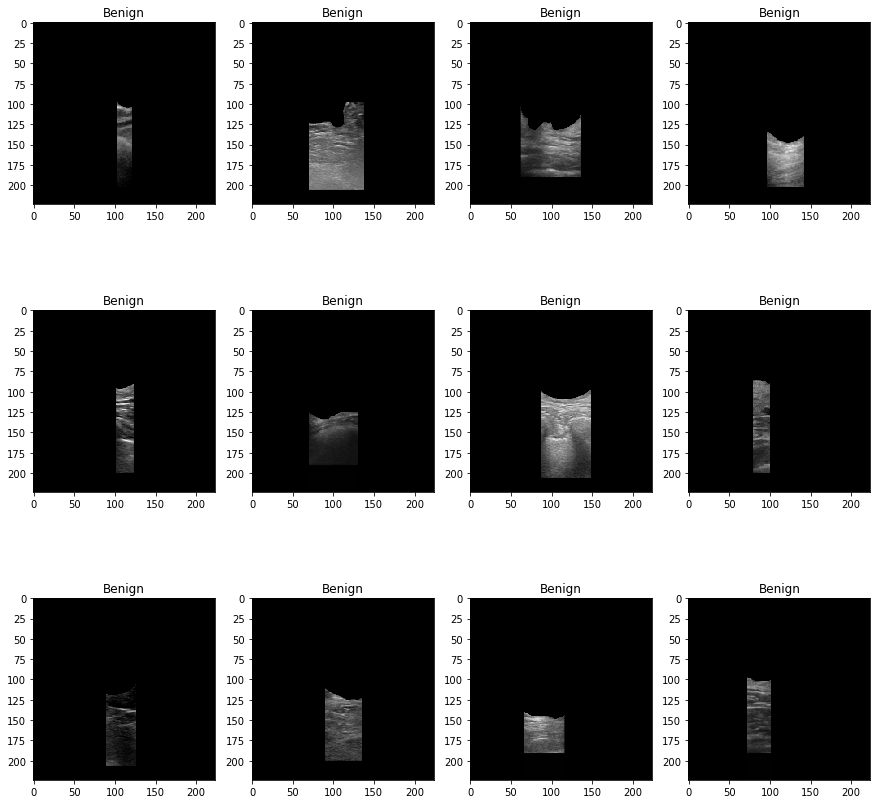

In [8]:
# # Display first 15 images of moles, and how they are classified
w=60
h=40
fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for i in range(1, columns*rows +1):
    ax = fig.add_subplot(rows, columns, i)
    if np.argmax(Y_train[i]) == 0:
        ax.title.set_text('Benign')
    else:
        ax.title.set_text('Mallignant')
    plt.imshow(x_train[i], interpolation='nearest')
plt.show()

In [9]:
BATCH_SIZE = 16

# Using original generator
train_generator = ImageDataGenerator(
        zoom_range=2,  # set range for random zoom
        rotation_range = 90,
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
    )

In [10]:
def build_model(backbone, lr=1e-4):
    model = Sequential()
    model.add(backbone)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(2, activation='softmax'))
    
    
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(lr=lr),
        metrics=['accuracy']
    )
    
    return model

In [11]:
K.clear_session()
gc.collect()

resnet = InceptionV3(
    weights='imagenet',
    include_top=False,
    input_shape=(224,224,3)
)


 


model = build_model(resnet ,lr = 1e-4)
model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 5, 5, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
batch_normalization_95 (Batc (None, 2048)              8192      
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 4098      
Total params: 21,815,074
Trainable params: 21,776,546
Non-trainable params: 38,528
_________________________________________________________________


In [12]:
# Learning Rate Reducer
learn_control = ReduceLROnPlateau(monitor='val_acc', patience=10,
                                  verbose=1,factor=0.2, min_lr=1e-7)

# Checkpoint
filepath="huaxi_Inception_huisheng_weights.best.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [13]:
history = model.fit_generator(
    train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE),
    steps_per_epoch=x_train.shape[0] / BATCH_SIZE,
    epochs=100,
    validation_data=(x_val, y_val),
    callbacks=[learn_control, checkpoint]
)

Epoch 1/100
18/17 [==============================] - 24s - loss: 0.9824 - acc: 0.5262 - val_loss: 0.9949 - val_acc: 0.3194
Epoch 2/100
18/17 [==============================] - 5s - loss: 1.1303 - acc: 0.5018 - val_loss: 0.5025 - val_acc: 0.8194
Epoch 3/100
18/17 [==============================] - 4s - loss: 0.8997 - acc: 0.5548 - val_loss: 0.7533 - val_acc: 0.5417
Epoch 4/100
18/17 [==============================] - 5s - loss: 0.7925 - acc: 0.6206 - val_loss: 0.4093 - val_acc: 0.8194
Epoch 5/100
18/17 [==============================] - 5s - loss: 0.8968 - acc: 0.5607 - val_loss: 0.4626 - val_acc: 0.8333
Epoch 6/100
18/17 [==============================] - 4s - loss: 0.8574 - acc: 0.6065 - val_loss: 0.5471 - val_acc: 0.8194
Epoch 7/100
18/17 [==============================] - 4s - loss: 0.8102 - acc: 0.5648 - val_loss: 0.5612 - val_acc: 0.8194
Epoch 8/100
18/17 [==============================] - 4s - loss: 0.8861 - acc: 0.5819 - val_loss: 0.4850 - val_acc: 0.7500
Epoch 9/100
18/17 [====

18/17 [==============================] - 4s - loss: 0.6363 - acc: 0.7005 - val_loss: 0.4306 - val_acc: 0.8333
Epoch 67/100
18/17 [==============================] - 4s - loss: 0.6122 - acc: 0.7211 - val_loss: 0.4304 - val_acc: 0.8333
Epoch 68/100
18/17 [==============================] - 4s - loss: 0.6800 - acc: 0.7072 - val_loss: 0.4297 - val_acc: 0.8333
Epoch 69/100
18/17 [==============================] - 4s - loss: 0.6794 - acc: 0.7252 - val_loss: 0.4310 - val_acc: 0.8333
Epoch 70/100
18/17 [==============================] - 4s - loss: 0.7058 - acc: 0.7007 - val_loss: 0.4327 - val_acc: 0.8333
Epoch 71/100
18/17 [==============================] - 4s - loss: 0.6958 - acc: 0.7002 - val_loss: 0.4313 - val_acc: 0.8333
Epoch 72/100
18/17 [==============================] - 4s - loss: 0.6571 - acc: 0.7037 - val_loss: 0.4340 - val_acc: 0.8333
Epoch 73/100
18/17 [==============================] - 4s - loss: 0.6124 - acc: 0.7005 - val_loss: 0.4320 - val_acc: 0.8333
Epoch 74/100
18/17 [=========

In [14]:
with open('history.json', 'w') as f:
    json.dump(str(history.history), f)

<AxesSubplot:>

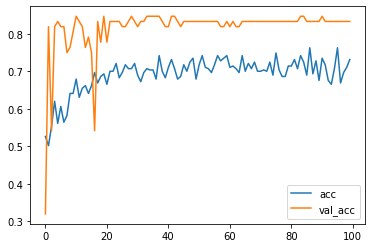

In [15]:
history_df = pd.DataFrame(history.history)
history_df[['acc', 'val_acc']].plot()

<AxesSubplot:>

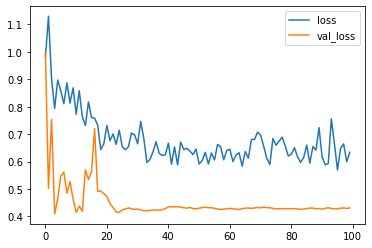

In [16]:
history_df = pd.DataFrame(history.history)
history_df[['loss', 'val_loss']].plot()

In [17]:
model.load_weights("huaxi_Inception_huisheng_weights.best.hdf5")

In [18]:
Y_val_pred = model.predict(x_val)

In [19]:
from sklearn.metrics import classification_report
print(classification_report(np.argmax(y_val, axis=1),np.argmax(Y_val_pred, axis=1),target_names=['benign','mallignant']))

              precision    recall  f1-score   support

      benign       0.85      0.98      0.91        59
  mallignant       0.75      0.23      0.35        13

    accuracy                           0.85        72
   macro avg       0.80      0.61      0.63        72
weighted avg       0.83      0.85      0.81        72



In [20]:
accuracy_score(np.argmax(y_val, axis=1), np.argmax(Y_val_pred, axis=1))

0.8472222222222222

In [21]:
Y_pred = model.predict(X_test)

In [22]:
tta_steps = 10
predictions = []

for i in tqdm(range(tta_steps)):
    preds = model.predict_generator(train_generator.flow(X_test, batch_size=BATCH_SIZE, shuffle=False),
                                    steps = len(X_test)/BATCH_SIZE)
    
    predictions.append(preds)
    gc.collect()
    
Y_pred_tta = np.mean(predictions, axis=0) # 计算每一列的均值

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.08it/s]


Confusion matrix, without normalization
[[83  6]
 [26  5]]


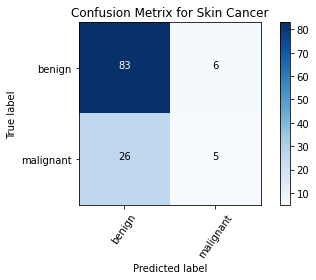

In [23]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=55)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

cm = confusion_matrix(np.argmax(Y_test1, axis=1), np.argmax(Y_pred, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

Confusion matrix, without normalization
[[87  2]
 [24  7]]


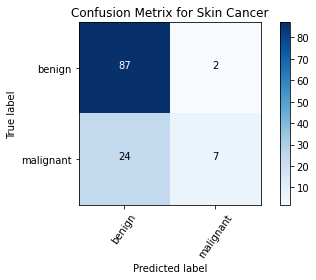

In [24]:
cm = confusion_matrix(np.argmax(Y_test1, axis=1), np.argmax(Y_pred_tta, axis=1))

cm_plot_label =['benign', 'malignant']
plot_confusion_matrix(cm, cm_plot_label, title ='Confusion Metrix for Skin Cancer')

In [28]:
from sklearn.metrics import classification_report
#classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
print(classification_report(np.argmax(Y_test1, axis=1),np.argmax(Y_pred, axis=1),target_names=['benign','mallignant']))

              precision    recall  f1-score   support

      benign       0.76      0.93      0.84        89
  mallignant       0.45      0.16      0.24        31

    accuracy                           0.73       120
   macro avg       0.61      0.55      0.54       120
weighted avg       0.68      0.73      0.68       120



In [29]:
from sklearn.metrics import classification_report
#classification_report( np.argmax(Y_test, axis=1), np.argmax(Y_pred_tta, axis=1))
print(classification_report(np.argmax(Y_test1, axis=1),np.argmax(Y_pred_tta, axis=1),target_names=['benign','mallignant']))

              precision    recall  f1-score   support

      benign       0.78      0.98      0.87        89
  mallignant       0.78      0.23      0.35        31

    accuracy                           0.78       120
   macro avg       0.78      0.60      0.61       120
weighted avg       0.78      0.78      0.74       120



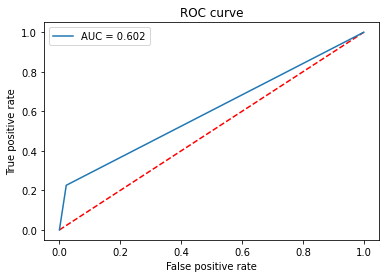

In [30]:
from sklearn.metrics import roc_auc_score, auc
from sklearn.metrics import roc_curve
roc_log = roc_auc_score(np.argmax(Y_test1, axis=1), np.argmax(Y_pred_tta, axis=1))
false_positive_rate, true_positive_rate, threshold = roc_curve(np.argmax(Y_test1, axis=1), np.argmax(Y_pred_tta, axis=1))
area_under_curve = auc(false_positive_rate, true_positive_rate)

plt.plot([0, 1], [0, 1], 'r--')
plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
#plt.savefig(ROC_PLOT_FILE, bbox_inches='tight')
plt.close()

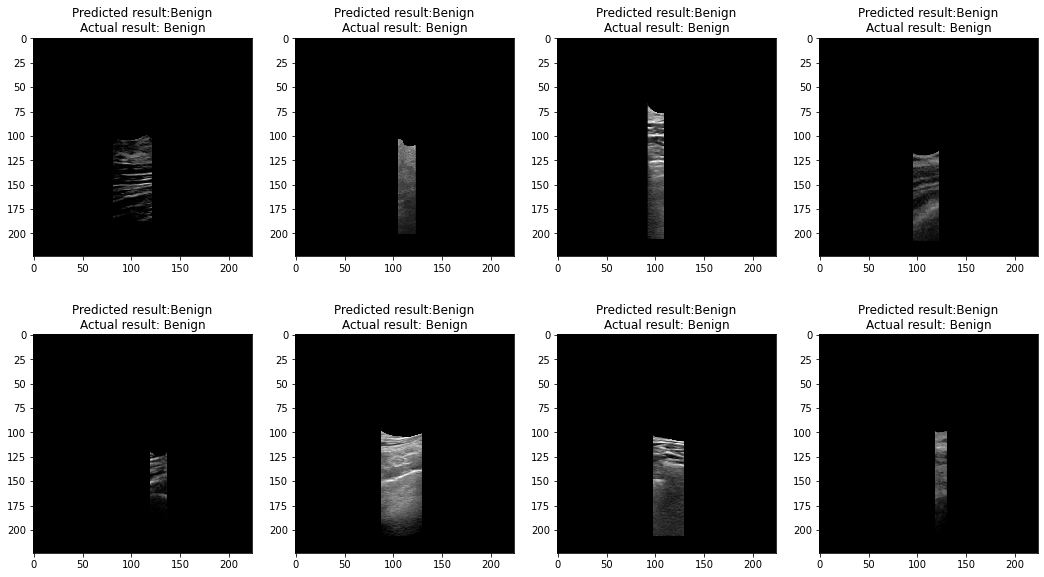

In [31]:
i=0
prop_class=[]
mis_class=[]

for i in range(len(Y_test1)):
    if(np.argmax(Y_test1[i])==np.argmax(Y_pred_tta[i])):
        prop_class.append(i)
    if(len(prop_class)==8):
        break

i=0
for i in range(len(Y_test1)):
    if(not np.argmax(Y_test1[i])==np.argmax(Y_pred_tta[i])):
        mis_class.append(i)
    if(len(mis_class)==8):
        break

# # Display first 8 images of benign
w=60
h=40
fig=plt.figure(figsize=(18, 10))
columns = 4
rows = 2

def Transfername(namecode):
    if namecode==0:
        return "Benign"
    else:
        return "Malignant"
    
for i in range(len(prop_class)):
    ax = fig.add_subplot(rows, columns, i+1)
    ax.set_title("Predicted result:"+ Transfername(np.argmax(Y_pred_tta[prop_class[i]]))
                       +"\n"+"Actual result: "+ Transfername(np.argmax(Y_test[prop_class[i]])))
    plt.imshow(X_test[prop_class[i]], interpolation='nearest')
plt.show()

In [32]:
layer_name = 'batch_normalization_95'
FC_layer_model = Model(inputs=model.input,
                                 outputs=model.get_layer(layer_name).output)

In [33]:
import glob
import cv2
import os
#Find the Features for n number of train images and we will get n x 2048
#This means we will get 2048 features for each images.

patth =  'C:/Users/user/Desktop/github/train'


j=0
features=np.zeros(shape=(X_train.shape[0],2048))
folders = list(filter(lambda x: os.path.isdir(os.path.join(patth, x)), os.listdir(patth)))
for i in folders:
  img_patth = os.path.join(patth,i)
  for img_path in glob.glob(img_patth + '/*.png'):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img,axis=0)
    FC_output = FC_layer_model.predict(img)
    features[j]=FC_output
    j+=1

In [34]:
features.shape

(359, 2048)

In [35]:
np.save('features', features)

In [36]:
#Name the feature rows as f_0, f_1, f_2...
feature_col=[]
for i in range(2048):
    feature_col.append("f_"+str(i))
    i+=1

In [37]:
#Create DataFrame with features and coloumn name

import pandas as pd 
train_features=pd.DataFrame(data=features,columns=feature_col)
feature_col = np.array(feature_col)

train_class = list(np.unique(Y_train))
print('Training Features Shape:', train_features.shape)
print('Training Labels Shape:', Y_train.shape)


Training Features Shape: (359, 2048)
Training Labels Shape: (359,)


In [58]:
np.savetxt("Y_train.csv", Y_train, delimiter=',')

In [39]:
train_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2038,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047
0,-0.401657,-0.190902,0.375625,-0.170986,-0.319577,0.048779,0.013124,-0.296068,-0.295055,0.267164,...,-0.317329,-0.114136,-0.355620,-0.441725,-0.572664,1.882860,0.010269,-0.503921,0.924401,-0.054371
1,-0.189790,-0.325746,-0.373032,-0.382304,-0.092761,-0.438196,-0.347913,-0.281416,-0.436496,0.318135,...,-0.152724,-0.406652,-0.155388,-0.452403,-0.022517,-0.161194,-0.330239,0.005871,-0.279417,-0.250494
2,-0.212834,-0.434512,-0.303795,1.372214,-0.207101,-0.040384,-0.264259,-0.377755,1.055299,0.297415,...,-0.356537,-0.233045,0.475480,-0.431740,-0.350618,-0.143326,-0.354598,-0.475948,-0.025751,1.018945
3,-0.381855,0.545515,0.564086,0.144235,-0.399756,-0.393013,-0.005459,-0.434017,0.754741,0.320041,...,-0.136564,-0.337154,0.182715,-0.461933,-0.346169,-0.226781,-0.374204,0.409825,1.080074,-0.241547
4,-0.405825,-0.436712,-0.367106,0.357550,-0.190926,0.668722,-0.355650,-0.423757,0.360051,0.211524,...,-0.143602,-0.338498,0.976029,-0.232570,-0.510459,-0.447983,-0.365962,-0.525133,0.083408,-0.220526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354,-0.196550,-0.416909,-0.277935,-0.351342,0.619650,-0.402718,-0.273624,-0.242323,0.218824,0.181709,...,-0.346345,-0.367563,0.728565,-0.461933,-0.375631,0.228340,-0.375979,0.053027,0.434417,-0.048534
355,-0.315458,-0.014763,-0.183064,0.861280,-0.321175,0.424431,-0.161916,-0.355120,0.760852,0.122357,...,-0.238715,0.281537,0.217571,-0.383863,-0.442248,-0.267418,-0.342553,-0.465536,-0.347108,0.212799
356,0.049551,-0.418040,-0.091010,-0.277261,-0.261326,-0.036008,-0.264487,-0.236357,-0.077547,-0.281217,...,-0.350550,0.231123,-0.093373,0.103920,0.436990,0.989658,-0.383001,0.012584,0.212188,-0.320282
357,-0.355875,-0.410122,0.088974,-0.329896,-0.318375,0.367898,-0.250810,-0.098696,0.456739,0.141007,...,-0.348128,-0.283031,0.037732,0.418920,-0.286799,0.918020,-0.385006,0.036439,2.783220,-0.220381


In [40]:
np.savetxt("huisheng.csv", train_features, delimiter=',')

In [42]:
import glob
import cv2
import os
#Find the Features for n number of train images and we will get n x 2048
#This means we will get 2048 features for each images.

patth =  'C:/Users/user/Desktop/github/validation'

k=0
features_test=np.zeros(shape=(Y_test.shape[0],2048))
folders = list(filter(lambda x: os.path.isdir(os.path.join(patth, x)), os.listdir(patth)))
for i in folders:
  img_patth = os.path.join(patth,i)
  for img_path in glob.glob(img_patth + '/*.png'):
    img = cv2.imread(img_path, cv2.IMREAD_COLOR)       
    img = cv2.resize(img, (224, 224))
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img = np.expand_dims(img,axis=0)
    FC_output = FC_layer_model.predict(img)
    features_test[k]=FC_output
    k+=1
 

In [43]:
np.save('features_test',features_test)

In [44]:
#Create DataFrame with features and coloumn name
import pandas as pd
test_features=pd.DataFrame(data=features_test,columns=feature_col)
feature_col = np.array(feature_col)

print('Test Features Shape:', test_features.shape)
print('Test Labels Shape:', Y_test.shape)

Test Features Shape: (120, 2048)
Test Labels Shape: (120,)


In [45]:
test_features

,f_0,f_1,f_2,f_3,f_4,f_5,f_6,f_7,f_8,f_9,...,f_2038,f_2039,f_2040,f_2041,f_2042,f_2043,f_2044,f_2045,f_2046,f_2047
0,-0.403521,0.429990,-0.125846,0.311693,-0.139437,-0.400963,0.234763,0.209001,-0.186684,0.137392,...,-0.279598,0.339781,-0.398155,0.062390,-0.551842,1.324324,0.244229,-0.322170,1.030640,-0.245734
1,-0.383598,0.107220,-0.071179,-0.299058,0.042813,-0.113250,-0.141215,-0.270312,0.033888,0.306956,...,-0.329493,-0.242919,0.945744,-0.404317,-0.309318,-0.306969,-0.380629,0.013246,-0.008919,0.682070
2,-0.386293,-0.307491,0.305382,0.629064,-0.230832,0.179447,-0.006510,-0.249927,1.763651,-0.150176,...,-0.289395,0.669769,1.473243,1.342854,-0.620224,2.043873,-0.388011,-0.251121,0.455894,1.014725
3,-0.380571,-0.104455,-0.370792,-0.358777,0.773473,-0.431930,0.158566,-0.016241,-0.127591,1.099436,...,0.034276,-0.361730,-0.301242,-0.461933,-0.265844,0.122933,-0.195803,0.383471,-0.283114,-0.222105
4,0.066194,-0.032394,-0.256750,-0.201211,0.040428,-0.433716,0.064637,-0.132610,-0.107386,0.237113,...,-0.356537,-0.261907,0.718830,-0.005875,-0.458402,-0.127903,-0.262281,-0.480495,0.039471,-0.169081
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,-0.368046,-0.171504,0.131462,-0.382304,-0.343725,-0.301925,0.290321,-0.220617,1.041099,0.449906,...,-0.356537,0.288875,0.283675,0.509366,-0.128724,-0.418487,-0.065077,1.439450,1.192866,-0.222949
116,-0.030648,-0.183030,-0.111173,-0.286145,-0.347901,-0.383526,-0.299740,-0.467296,-0.002487,0.025080,...,-0.355444,-0.091360,0.550526,0.392964,-0.468218,-0.321841,-0.384963,0.170358,1.087465,-0.185830
117,-0.403551,-0.183342,-0.199007,-0.357842,-0.074519,-0.422288,-0.163759,-0.251472,0.020225,0.634285,...,-0.154031,-0.325093,0.161183,-0.447825,-0.263627,-0.345415,-0.371412,0.349903,-0.265120,-0.153619
118,-0.346835,0.067345,-0.254931,0.244206,-0.275215,-0.052465,0.135493,-0.369253,0.007511,0.217311,...,0.179747,-0.276696,0.060671,-0.352223,-0.279701,-0.173872,-0.360922,-0.285132,-0.200829,-0.222931


In [46]:
np.savetxt("huisheng_test.csv", test_features, delimiter=',')